In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ravidussilva/real-ai-art")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/ravidussilva/real-ai-art


In [26]:
import os
import glob
from PIL import Image

impressionism_path = os.path.join(path, 'Real_AI_SD_LD_Dataset', 'train', 'AI_SD_impressionism')

print(f"Attempting to find images in: {impressionism_path}")

if not os.path.exists(impressionism_path):
    print(f"Error: The directory '{impressionism_path}' does not exist.")
    print(f"Contents of '{os.path.join(path, 'Real_AI_SD_LD_Dataset', 'train')}': {os.listdir(os.path.join(path, 'Real_AI_SD_LD_Dataset', 'train'))}")
else:
    print(f"Directory '{impressionism_path}' exists. Contents: {os.listdir(impressionism_path)[:10]} ... (showing first 10 items if more than 10)")


image_files = []
for ext in ('*.jpg', '*.jpeg', '*.png'):
    current_glob_pattern = os.path.join(impressionism_path, '**', ext)
    print(f"Searching for files with pattern: {current_glob_pattern}")
    found_files = glob.glob(current_glob_pattern, recursive=True)
    image_files.extend(found_files)
    print(f"Found {len(found_files)} files for extension '{ext}' in this pattern.")

selected_image_paths = image_files[:2000]

images = []
for img_path in selected_image_paths:
    try:
        img = Image.open(img_path)
        img.load()  # Force loading of image data immediately to catch truncation errors early
        images.append(img)
    except OSError as e: # Catch OSError specifically for image truncation issues
        print(f"Could not load or process {img_path} due to OSError: {e}. Skipping this image.")
    except Exception as e: # Catch other potential errors during image opening
        print(f"Could not load {img_path}: {e}. Skipping this image.")

print(f"Loaded {len(images)} images from the 'AI_SD_impressionism' folder.")

Attempting to find images in: /kaggle/input/datasets/ravidussilva/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
Directory '/kaggle/input/datasets/ravidussilva/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism' exists. Contents: ['3-876312147-715826.jpg', '3-760593143-881001.jpg', '3-993772242-23122.jpg', '3-97333810-436649.jpg', '3-61085525-482388.jpg', '3-242639205-290902.jpg', '3-865674855-795539.jpg', '3-572488398-289883.jpg', '3-474788376-431126.jpg', '3-817879784-505016.jpg'] ... (showing first 10 items if more than 10)
Searching for files with pattern: /kaggle/input/datasets/ravidussilva/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism/**/*.jpg
Found 5388 files for extension '*.jpg' in this pattern.
Searching for files with pattern: /kaggle/input/datasets/ravidussilva/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism/**/*.jpeg
Found 0 files for extension '*.jpeg' in this pattern.
Searching for files with pattern: /kaggle/input/datasets

Displaying the first loaded image:


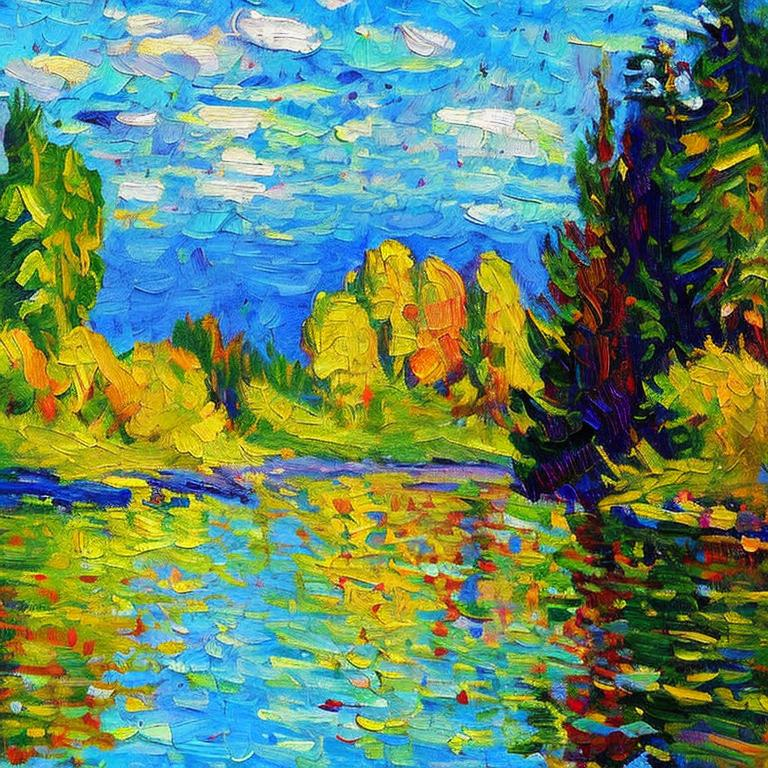

In [27]:
if images:
    print("Displaying the first loaded image:")
    display(images[0])
else:
    print("No images were loaded.")

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize to [-1, 1]
])

class CustomImageDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        if self.transform:
            image = self.transform(image)
        return image

dataset = CustomImageDataset(images, transform=transform)

batch_size = 32

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train DataLoader created with {len(train_dataloader)} batches.")
print(f"Test DataLoader created with {len(test_dataloader)} batches.")

Total dataset size: 2000
Training set size: 1600
Testing set size: 400
Train DataLoader created with 50 batches.
Test DataLoader created with 13 batches.


In [31]:
for i, batch_data in enumerate(train_dataloader):
    print(f"Shape of one batch from train_dataloader: {batch_data.shape}")
    break

Shape of one batch from train_dataloader: torch.Size([32, 3, 64, 64])


In [32]:
timesteps = 1000
beta_start = 1e-4
beta_end   = 0.02

betas = torch.linspace(beta_start, beta_end, timesteps).to(device)                 # (T,)
alphas = 1.0 - betas                                                               # (T,)
alphas_cumprod = torch.cumprod(alphas, dim=0)                                      # (T,)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]], dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

print("betas:", betas.shape)
print("alphas_cumprod:", alphas_cumprod.shape)


betas: torch.Size([1000])
alphas_cumprod: torch.Size([1000])


In [33]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_acp_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_om_acp_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    x_noisy = sqrt_acp_t * x_start + sqrt_om_acp_t * noise
    return x_noisy, noise


In [34]:
import math

def timestep_embedding(t, dim=128):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device).float() / half)
    args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb


In [35]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.net(x)

class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128, base_ch=64):
        super().__init__()
        self.time_dim = time_dim

        # time MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        # Down
        self.conv0 = ConvBlock(3, base_ch)               # 64x64
        self.down1 = nn.MaxPool2d(2)                     # 32x32
        self.conv1 = ConvBlock(base_ch, base_ch*2)       # 32x32
        self.down2 = nn.MaxPool2d(2)                     # 16x16
        self.conv2 = ConvBlock(base_ch*2, base_ch*4)     # 16x16

        # time to channels
        self.to_time0 = nn.Linear(time_dim, base_ch)
        self.to_time1 = nn.Linear(time_dim, base_ch*2)
        self.to_time2 = nn.Linear(time_dim, base_ch*4)

        # Up
        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")  # 32x32
        self.up_conv1 = ConvBlock(base_ch*4 + base_ch*2, base_ch*2)

        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")  # 64x64
        self.up_conv2 = ConvBlock(base_ch*2 + base_ch, base_ch)

        # Output noise prediction
        self.out = nn.Conv2d(base_ch, 3, 1)

    def forward(self, x, t):
        # t embedding
        t_emb = timestep_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        # Down path
        x0 = self.conv0(x)
        x0 = x0 + self.to_time0(t_emb).view(-1, x0.size(1), 1, 1)

        x1 = self.down1(x0)
        x1 = self.conv1(x1)
        x1 = x1 + self.to_time1(t_emb).view(-1, x1.size(1), 1, 1)

        x2 = self.down2(x1)
        x2 = self.conv2(x2)
        x2 = x2 + self.to_time2(t_emb).view(-1, x2.size(1), 1, 1)

        # Up path
        u1 = self.up1(x2)
        u1 = torch.cat([u1, x1], dim=1)
        u1 = self.up_conv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, x0], dim=1)
        u2 = self.up_conv2(u2)

        return self.out(u2)


In [36]:
model = SimpleUNet(time_dim=128, base_ch=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

print("Model params:", sum(p.numel() for p in model.parameters())/1e6, "M")

Model params: 1.976643 M


In [37]:
epochs = 800

model.train()
for epoch in range(epochs):
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    total_loss = 0.0

    for x0 in pbar:
        x0 = x0.to(device)

        t = torch.randint(0, timesteps, (x0.size(0),), device=device).long()
        x_noisy, noise = q_sample(x0, t)

        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item(), avg=total_loss/(pbar.n+1))


Epoch 800/800: 100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg=0.0564, loss=0.0972]


In [41]:
@torch.no_grad()
def p_sample(model, x, t):
    t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

    beta_t = betas[t]
    alpha_t = alphas[t]
    acp_t = alphas_cumprod[t]

    eps = model(x, t_batch)

    # mean
    x = (1.0 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - acp_t) * eps)

    if t > 0:
        x = x + torch.sqrt(beta_t) * torch.randn_like(x)

    return x

@torch.no_grad()
def sample(model, n=8):
    model.eval()
    x = torch.randn(n, 3, 64, 64, device=device)

    for t in tqdm(reversed(range(timesteps)), desc="Sampling"):
        x = p_sample(model, x, t)

    return x


Sampling: 1000it [00:12, 79.29it/s]


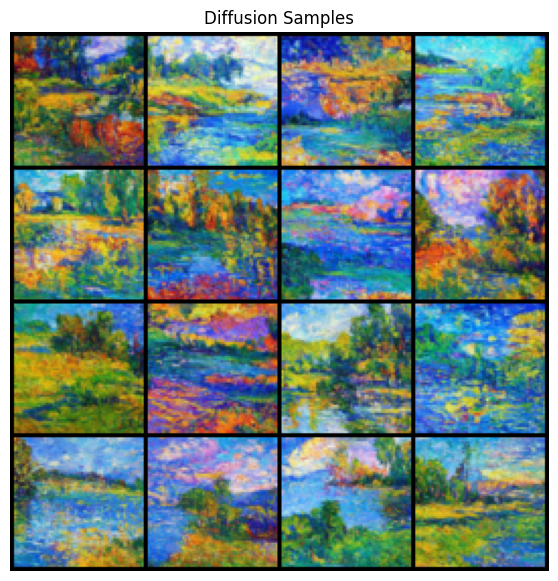

In [44]:
@torch.no_grad()
def show_images(x, nrow=4, title="samples"):
    x = x.detach().cpu()
    x = (x + 1) / 2
    x = x.clamp(0, 1)

    grid = torchvision.utils.make_grid(x, nrow=nrow)
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.show()

samples = sample(model, n=16)
show_images(samples, nrow=4, title="Diffusion Samples")